<a href="https://colab.research.google.com/github/Vennyx14/Finbert_SOTA/blob/main/FinBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Setup & Config**


In [ ]:
!pip install -q transformers torch pandas scikit-learn tqdm

import random, os, math, time

import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
    logging
)

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
logging.set_verbosity_warning()


In [ ]:
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)

set_seed(42)

class Config:
    MODEL_NAME = "ProsusAI/finbert"

    MAX_LEN = 128
    TRAIN_BATCH_SIZE = 16
    VALID_BATCH_SIZE = 16
    EPOCHS = 10
    LR = 2e-5

    ACCUM_STEPS = 2

    WEIGHT_DECAY = 0.01
    WARMUP_RATIO = 0.1
    NUM_LABELS = 3
    OUTPUT_DIR = "./model_checkpoints"
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    SEED = 42

print("Device:", Config.DEVICE)

Device: cuda


# **2.Data Preparation**

##Normalize & Load dataset

In [ ]:
def normalize_labels(series):
    """
    Normalize labels to:
    0 = negative, 1 = neutral, 2 = positive
    """
    # Case 1: string labels
    if series.dtype == object:
        s = series.astype(str).str.lower().str.strip()

        label_map = {
            "negative": 0,
            "neg": 0,
            "bearish": 0,

            "neutral": 1,
            "neu": 1,

            "positive": 2,
            "pos": 2,
            "bullish": 2
        }

        mapped = s.map(label_map)

        if mapped.isna().any():
            bad = s[mapped.isna()].unique()
            raise ValueError(f"Unknown label values: {bad}")

        return mapped.astype(int)

    # Case 2: numeric labels
    else:
        unique_vals = sorted(series.unique())

        # Common cases
        if set(unique_vals) == {0, 1, 2}:
            return series.astype(int)

        if set(unique_vals) == {-1, 0, 1}:
            return series.map({-1: 0, 0: 1, 1: 2}).astype(int)

        raise ValueError(f"Unrecognized numeric labels: {unique_vals}")


In [ ]:
def load_data(path):
  df = pd.read_csv(path)

  df.columns = [c.lower().strip() for c in df.columns]

  # find text col
  if "text" in df.columns:
    pass
  elif "sentence" in df.columns:
    df.rename(columns={"sentence": "text"}, inplace=True)

  # find label col
  if "label" in df.columns:
    pass
  elif "sentiment" in df.columns:
    df.rename(columns={"sentiment": "label"}, inplace=True)

  df = df.dropna(subset=["text", "label"])

  df["text"] = (
        df["text"]
        .astype(str)
        .str.replace("\n", " ", regex=False)
        .str.strip()
    )

  df["label"] = normalize_labels(df["label"])
  df["label"] = df["label"].astype(int)

  return df

tokenizer = AutoTokenizer.from_pretrained(Config.MODEL_NAME)

# Dataset
class CryptoDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = list(texts)
        self.labels = list(labels)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        txt = str(self.texts[idx])
        enc = self.tokenizer(
            txt,
            max_length=self.max_len,
            truncation=True,
            padding=False,
            return_tensors=None
        )
        # enc['input_ids'] và enc['attention_mask'] là list[int]
        item = {
            "input_ids": enc["input_ids"],
            "attention_mask": enc["attention_mask"],
            "labels": int(self.labels[idx])
        }

        if "token_type_ids" in enc:
            item["token_type_ids"] = enc["token_type_ids"]
        return item

# Collate: dynamic padding + trả tensors
def collate_fn(batch):
    # batch: list of dicts with lists for ids/mask
    input_ids = [b["input_ids"] for b in batch]
    attention_mask = [b["attention_mask"] for b in batch]
    to_pad = {"input_ids": input_ids, "attention_mask": attention_mask}

    if "token_type_ids" in batch[0]:
        to_pad["token_type_ids"] = [b["token_type_ids"] for b in batch]

    padded = tokenizer.pad(
    to_pad,
    padding=True,
    return_tensors="pt"
    )
    labels = torch.tensor([b["labels"] for b in batch], dtype=torch.long)

    padded["labels"] = labels
    return padded


##Test

In [ ]:
df = load_data("/data.csv")

print(df.head())
print(df["label"].value_counts())

                                                text  label
0  The GeoSolutions technology will leverage Bene...      2
1  $ESI on lows, down $1.50 to $2.50 BK a real po...      0
2  For the last quarter of 2010 , Componenta 's n...      2
3  According to the Finnish-Russian Chamber of Co...      1
4  The Swedish buyout firm has sold its remaining...      1
label
1    3130
2    1852
0     860
Name: count, dtype: int64


In [ ]:

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["text"],
    df["label"],
    test_size=0.2,
    stratify=df["label"],
    random_state=Config.SEED
)

train_dataset = CryptoDataset(
    train_texts,
    train_labels,
    tokenizer,
    Config.MAX_LEN
)

train_loader = DataLoader(
    train_dataset,
    batch_size=Config.TRAIN_BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2,
    pin_memory=True
)

batch = next(iter(train_loader))

print("input_ids shape:", batch["input_ids"].shape)
print("labels shape:", batch["labels"].shape)

# Tạo Dataset cho tập Validation
val_dataset = CryptoDataset(
    val_texts,
    val_labels,
    tokenizer,
    Config.MAX_LEN
)

val_loader = DataLoader(
    val_dataset,
    batch_size=Config.VALID_BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2,
    pin_memory=True
)

print(f"Số batch trong tập Train: {len(train_loader)}")
print(f"Số batch trong tập Val: {len(val_loader)}")


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


input_ids shape: torch.Size([16, 41])
labels shape: torch.Size([16])
Số batch trong tập Train: 293
Số batch trong tập Val: 74


# **3. Model Setup**

##Load FinBERT + Classification Head

In [ ]:
def get_model():
    model = AutoModelForSequenceClassification.from_pretrained(
        Config.MODEL_NAME,
        num_labels=Config.NUM_LABELS
    )

    model.to(Config.DEVICE)
    return model


model = get_model()

In [ ]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

##Optimizer

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [p for n,p in param_optimizer if not any(nd in n for nd in no_decay)],
        "weight_decay": Config.WEIGHT_DECAY,
    },
    {
        "params": [p for n,p in param_optimizer if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0
    }
]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=Config.LR,
    eps=1e-8
)


##Warmup & Scheduler Setup

In [ ]:
num_training_steps = int(len(train_loader) * Config.EPOCHS / Config.ACCUM_STEPS)
num_warmup_steps = int(Config.WARMUP_RATIO * num_training_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

##AMP-Mixed precision

In [ ]:
scaler = torch.cuda.amp.GradScaler()

print(f"Total training steps: {num_training_steps}")
print("Model Setup Complete.")

Total training steps: 1465
Model Setup Complete.


# **4. Training Engine**


In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None, reduction="mean"):
        super().__init__()
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction

    def forward(self, logits, targets):
        ce = F.cross_entropy(
            logits,
            targets,
            weight=self.weight,
            reduction="none"
        )
        pt = torch.exp(-ce)
        loss = ((1 - pt) ** self.gamma) * ce

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        return loss

In [ ]:
# Optional: create output dir
os.makedirs(Config.OUTPUT_DIR, exist_ok=True)

# Helpers
def get_lr(optimizer):
    for g in optimizer.param_groups:
        return g['lr']

def save_checkpoint(model, tokenizer, optimizer, scheduler, epoch, path):
    os.makedirs(path, exist_ok=True)
    # Save model + tokenizer + optimizer + scheduler states
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None
    }, os.path.join(path, "training_state.pt"))
    # Saving model & tokenizer for inference
    model.save_pretrained(path)
    tokenizer.save_pretrained(path)

def load_checkpoint(path, model, optimizer=None, scheduler=None, device=None):
    ckpt = torch.load(os.path.join(path, "training_state.pt"), map_location=device)
    model.load_state_dict(ckpt['model_state_dict'])
    if optimizer is not None and ckpt.get('optimizer_state_dict') is not None:
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])
    if scheduler is not None and ckpt.get('scheduler_state_dict') is not None:
        scheduler.load_state_dict(ckpt['scheduler_state_dict'])
    return ckpt.get('epoch', None)

# If you want class weights (tensor on CPU), convert to device inside training
def to_device_batch(batch, device):
    # Move all tensors in batch dict to device
    for k, v in batch.items():
        if isinstance(v, torch.Tensor):
            batch[k] = v.to(device)
    return batch

def train_one_epoch(model,dataloader,optimizer,criterion,scheduler=None,epoch=0,
                    scaler=None,accumulation_steps=1,device=None,max_grad_norm=1.0):

    model.train()
    total_loss = 0.0
    step = 0

    optimizer.zero_grad()
    pbar = tqdm(dataloader, desc=f"Train E{epoch}")

    for i, batch in enumerate(pbar):
        step += 1

        # move batch to device
        batch = to_device_batch(batch, device)

        labels = batch["labels"]

        with torch.cuda.amp.autocast(enabled=(scaler is not None)):
            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                token_type_ids=batch.get("token_type_ids", None)
            )
            logits = outputs.logits

            loss = criterion(logits, labels)
            loss = loss / accumulation_steps

        # backward
        if scaler is not None:
            scaler.scale(loss).backward()
        else:
            loss.backward()

        # update
        if (i + 1) % accumulation_steps == 0:
            if scaler is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                scaler.step(optimizer)
                scaler.update()
            else:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                optimizer.step()

            if scheduler is not None:
                scheduler.step()

            optimizer.zero_grad()

        total_loss += loss.item() * accumulation_steps
        pbar.set_postfix(
            loss=f"{total_loss/step:.4f}",
            lr=f"{optimizer.param_groups[0]['lr']:.2e}"
        )

    return total_loss / step

# Evaluation function
def evaluate(model, dataloader, device=None):
    model.eval()
    preds = []
    trues = []
    probs_all = []
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc="Eval")
    with torch.no_grad():
        for i, batch in pbar:
            batch = to_device_batch(batch, device)
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            token_type_ids = batch.get('token_type_ids', None)
            labels = batch['labels']

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids
            )
            logits = outputs.logits
            probs = torch.softmax(logits, dim=-1)
            pred = torch.argmax(probs, dim=-1)

            preds.extend(pred.detach().cpu().tolist())
            trues.extend(labels.detach().cpu().tolist())
            probs_all.extend(probs.detach().cpu().tolist())

    # Metrics
    weighted_f1 = f1_score(trues, preds, average='weighted')
    macro_f1 = f1_score(trues, preds, average='macro')
    report = classification_report(trues, preds, digits=4, output_dict=True)
    cm = confusion_matrix(trues, preds)
    return {
        'weighted_f1': weighted_f1,
        'macro_f1': macro_f1,
        'report': report,
        'confusion_matrix': cm,
        'preds': preds,
        'trues': trues,
        'probs': probs_all
    }


In [ ]:
class_weights = torch.tensor(
    class_weights,
    dtype=torch.float32,
    device=Config.DEVICE
)

criterion = FocalLoss(
    gamma=2.0,
    weight=class_weights.to(device = Config.DEVICE)
)

In [ ]:
def train_loop(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    epochs=Config.EPOCHS,
    accumulation_steps=Config.ACCUM_STEPS,
    class_weights=None,
    patience=3,
    device=Config.DEVICE,
    output_dir=Config.OUTPUT_DIR,
    max_grad_norm=1.0,
    use_amp=True
):
    scaler = torch.cuda.amp.GradScaler() if use_amp and device.type == 'cuda' else None

    # ✅ CREATE CRITERION HERE
    if class_weights is not None:
        criterion = FocalLoss(
            gamma=2.0,
            weight=class_weights.to(device)
        )
    else:
        criterion = torch.nn.CrossEntropyLoss()

    best_val_f1 = -1
    best_epoch = -1
    epochs_no_improve = 0

    for epoch in range(1, epochs + 1):
        start_time = time.time()

        train_loss = train_one_epoch(
            model=model,
            dataloader=train_loader,
            optimizer=optimizer,
            criterion=criterion,
            scheduler=scheduler,
            epoch=epoch,
            scaler=scaler,
            accumulation_steps=accumulation_steps,
            device=device,
            max_grad_norm=max_grad_norm
        )

        val_metrics = evaluate(model, val_loader, device=device)
        val_macro_f1 = val_metrics["macro_f1"]

        print(f"\nEpoch {epoch}")
        print(f"Train loss: {train_loss:.4f}")
        print(f"Val macro F1: {val_macro_f1:.4f}")

        if val_macro_f1 > best_val_f1:
            best_val_f1 = val_macro_f1
            best_epoch = epoch
            epochs_no_improve = 0

            ckpt_path = os.path.join(
                output_dir,
                f"best_model_epoch{epoch}_macroF1{val_macro_f1:.4f}"
            )
            save_checkpoint(model, tokenizer, optimizer, scheduler, epoch, ckpt_path)
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    return best_val_f1


In [ ]:
# ===== Compute class weights =====
train_labels_array = np.array(train_labels)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels_array),
    y=train_labels_array
)

class_weights_tensor = torch.tensor(
    class_weights, dtype=torch.float
).to(Config.DEVICE)

print(f"Class Weights: {class_weights_tensor}")

# ===== Train =====
print(f"\n TRAINING FOR {Config.EPOCHS} EPOCHS")

best_f1_score = train_loop(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=Config.EPOCHS,
    accumulation_steps=Config.ACCUM_STEPS,
    class_weights=class_weights_tensor,
    patience=3,
    device=Config.DEVICE,
    output_dir=Config.OUTPUT_DIR
)

print(f"\n FINAL RESULT — Best Macro F1: {best_f1_score:.4f}")

Class Weights: tensor([2.2641, 0.6221, 1.0518], device='cuda:0')

 TRAINING FOR 10 EPOCHS


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Train E1:   0%|          | 0/293 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `_

Eval:   0%|          | 0/74 [00:00<?, ?it/s]


Epoch 1
Train loss: 1.0529
Val macro F1: 0.7460


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Train E2:   0%|          | 0/293 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Eval:   0%|          | 0/74 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



Epoch 2
Train loss: 0.1734
Val macro F1: 0.7456


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Train E3:   0%|          | 0/293 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `_

Eval:   0%|          | 0/74 [00:00<?, ?it/s]


Epoch 3
Train loss: 0.1031
Val macro F1: 0.7764


Train E4:   0%|          | 0/293 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `_

Eval:   0%|          | 0/74 [00:00<?, ?it/s]


Epoch 4
Train loss: 0.0712
Val macro F1: 0.7778


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Train E5:   0%|          | 0/293 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Eval:   0%|          | 0/74 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



Epoch 5
Train loss: 0.0563
Val macro F1: 0.7780


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Train E6:   0%|          | 0/293 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Eval:   0%|          | 0/74 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



Epoch 6
Train loss: 0.0532
Val macro F1: 0.7741


Train E7:   0%|          | 0/293 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `_

Eval:   0%|          | 0/74 [00:00<?, ?it/s]


Epoch 7
Train loss: 0.0473
Val macro F1: 0.7618


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Train E8:   0%|          | 0/293 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Eval:   0%|          | 0/74 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



Epoch 8
Train loss: 0.0438
Val macro F1: 0.7738
Early stopping at epoch 8

 FINAL RESULT — Best Macro F1: 0.7780


# **5. Evaluation & Analysis**

In [ ]:
model.eval()

all_preds = []
all_trues = []
all_probs = []

with torch.no_grad():
    for batch in val_loader:
        batch = {k: v.to(Config.DEVICE) for k, v in batch.items()}
        outputs = model(**batch)

        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)

        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_trues.extend(batch["labels"].cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_trues = np.array(all_trues)
all_probs = np.array(all_probs)


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


              precision    recall  f1-score   support

    negative     0.4892    0.7907    0.6044       172
     neutral     0.9117    0.7748    0.8377       626
    positive     0.8942    0.8652    0.8795       371

    accuracy                         0.8058      1169
   macro avg     0.7650    0.8102    0.7738      1169
weighted avg     0.8439    0.8058    0.8166      1169



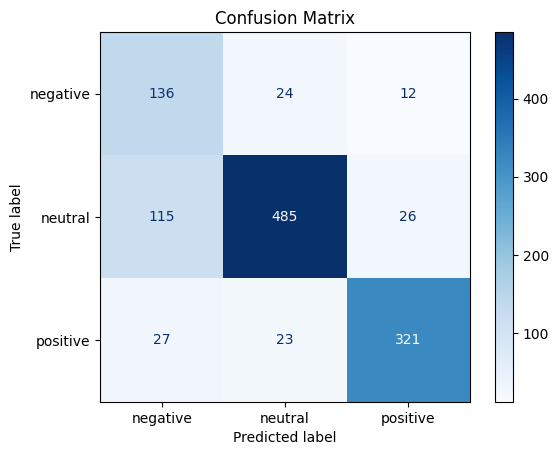

In [ ]:
print(classification_report(
    all_trues,
    all_preds,
    target_names=["negative", "neutral", "positive"],
    digits=4
))

cm = confusion_matrix(all_trues, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["negative", "neutral", "positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Lấy index các lỗi
wrong_idx = np.where(all_preds != all_trues)[0]

# Sắp xếp theo độ tự tin của dự đoán sai (max prob)
confidence = all_probs[wrong_idx].max(axis=1)
top_wrong = wrong_idx[np.argsort(-confidence)][:10]

for i in top_wrong:
    print("TEXT:")
    print(val_texts.iloc[i])
    print(f"TRUE: {all_trues[i]} | PRED: {all_preds[i]} | PROBS: {all_probs[i]}")
    print("-" * 80)

TEXT:
Sales boost for new Morrisons chief David Potts as Tesco turnaround stalls
TRUE: 0 | PRED: 2 | PROBS: [0.00670314 0.01319686 0.9801    ]
--------------------------------------------------------------------------------
TEXT:
RT @jan $ARNA Don't think buyout rumor strong enough too be driving this up just yet...when it is this may fly like aapl...// fly how high?
TRUE: 1 | PRED: 2 | PROBS: [0.00963424 0.01173775 0.978628  ]
--------------------------------------------------------------------------------
TEXT:
Following the issue , the number of shares in the Swedish company will grow by 9 % .
TRUE: 1 | PRED: 2 | PROBS: [0.00226242 0.02367828 0.9740592 ]
--------------------------------------------------------------------------------
TEXT:
It is necessary to strengthen the company 's operations , however .
TRUE: 1 | PRED: 2 | PROBS: [0.00594684 0.02215345 0.9718997 ]
--------------------------------------------------------------------------------
TEXT:
Apart from Nordea , also Ergo 

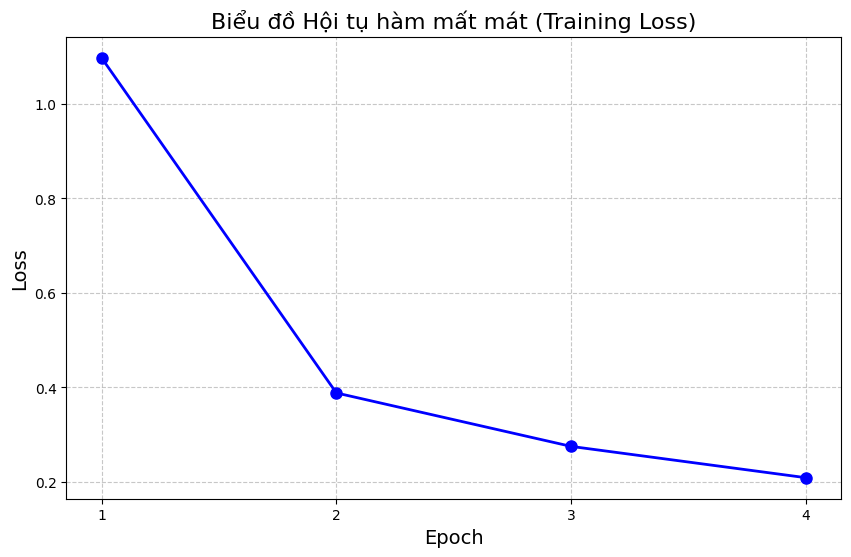

In [2]:
# --- 1. VẼ BIỂU ĐỒ LOSS (Dựa trên log thực tế của bạn) ---
epochs = [1, 2, 3, 4]
train_losses = [1.0980, 0.3883, 0.2751, 0.2088] # Số liệu từ log của bạn

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, marker='o', linestyle='-', color='b', linewidth=2, markersize=8)
plt.title('Biểu đồ Hội tụ hàm mất mát (Training Loss)', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(epochs)
plt.savefig('loss_chart.png', dpi=300) # Lưu ảnh nét cao
plt.show()
